<a href="https://colab.research.google.com/github/Mervvick/AI_Timeline_Pro/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%7C_%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D1%85_%D1%81%D0%B5%D1%82%D0%B5%D0%B9_%7C_%D0%94%D0%97_Pro_%7C_%D0%A3%D0%98%D0%98%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Используйте базу акций Лукойла.

Сделайте несколько усовершенствований в предсказании временного ряда.
Добавьте к исходному сигналу расширенные данные:

* попарные разности каналов
* модули попарных разностей каналов
* попарные произведения каналов
* обратное значение каналов x_new = 1/(x + 1e-3)
* первые производные каналов (x[n] - x[n-1])
* вторые производные каналов (x[n] - 2*x[n-1] + x[n-2])

Примените абсолютно новый подход. Сделайте бОльший “просмотр сети в прошлое”, при формировании входного сигнала используйте:

* 100 точек с шагом назад по 1,

* 100 точек с шагом назад по 10 (или сами точки, или среднее по отрезку в 10 точек).
* Объедините эти точки

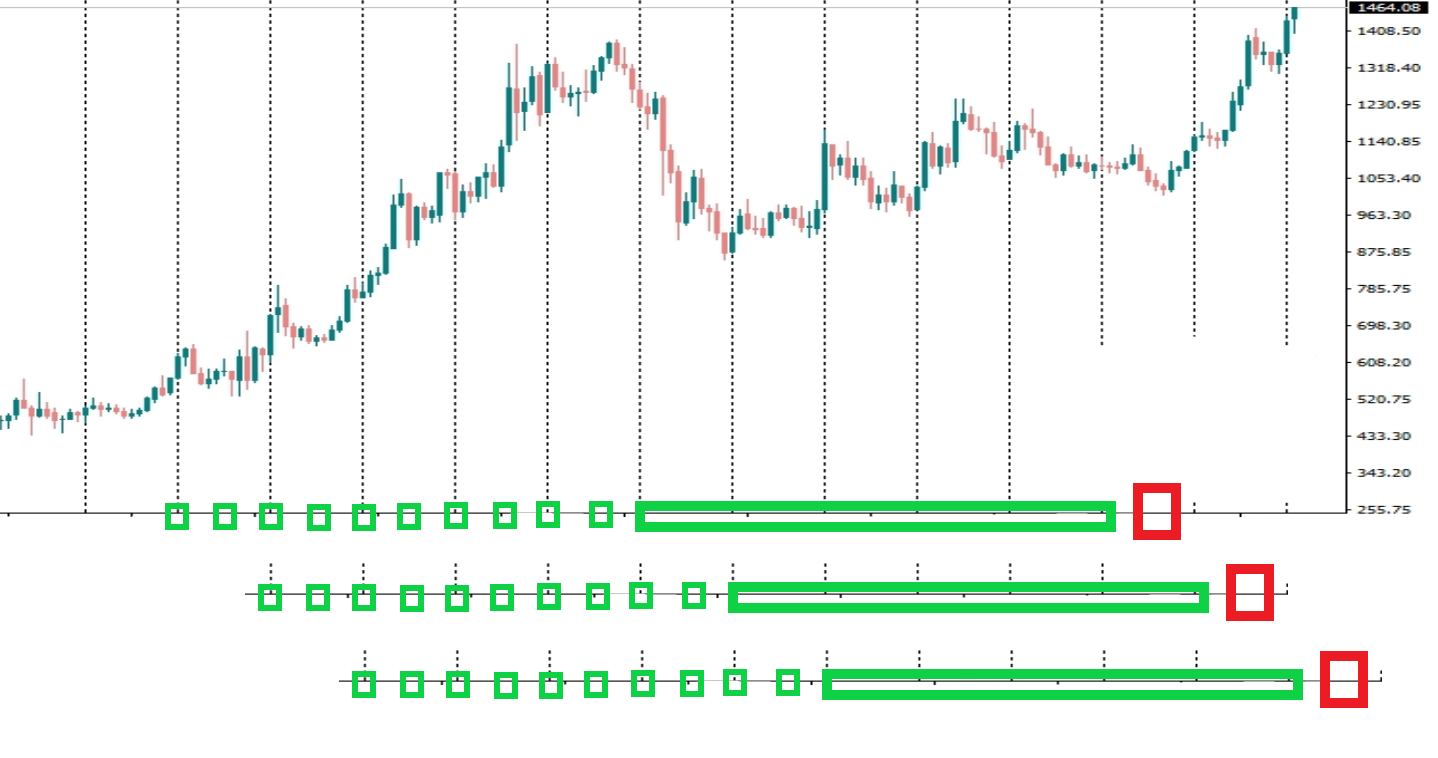

## Подготовка

In [ ]:
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model, load_model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM, MaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Коллбэк
from tensorflow.keras.callbacks import LearningRateScheduler

# Загрузка датасетов из облака google
import gdown

# Отрисовка графиков
import matplotlib.pyplot as plt

# Отрисовка графики в ячейке colab
%matplotlib inline

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Назначение размера и стиля графиков по умолчанию

from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

In [ ]:
# Загрузка датасетов из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/16_17.csv', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l11/18_19.csv', None, quiet=True)

'18_19.csv'

In [ ]:
# Чтение данных в таблицы с удалением ненужных столбцов

data16_17 = pd.read_csv('16_17.csv', sep=';').drop(columns=['DATE', 'TIME'])
data18_19 = pd.read_csv('18_19.csv', sep=';').drop(columns=['DATE', 'TIME'])

In [ ]:
# Просмотр размерностей получившихся таблиц

print(data16_17.shape)
print(data18_19.shape)

(263925, 5)
(217947, 5)


In [ ]:
# Создание общего набора данных из двух датасетов

data = pd.concat([data16_17,data18_19])   # Объединение датасетов
data = data.reset_index(drop = True)      # Обнуление индексов

# Проверка формы данных
print(data.shape)

(481872, 5)


In [ ]:
# Получение названий столбцов

col = data.columns
print(col)

Index(['OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME'], dtype='object')


In [ ]:
# Задание циклов для столбцов таким образом, чтобы происходил перебор всех возможных пар:
# Перебор индексов массива с именами столбцов 'OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME',
# получая пары 'OPEN' и 'MAX', 'OPEN' и 'MIN', 'OPEN' и 'CLOSE' ..., 'MAX' и 'MIN', 'MAX' и 'CLOSE' и т.д

for i in range(col.shape[0]): # Для всех пар
    for j in range(i + 1 , col.shape[0]): # Расчет
        data[col[i] + '-' + col[j]] = data[col[i]] - data[col[j]] # Разности
        data['|' + col[i] + '-' + col[j] + '|'] = abs(data[col[i]] - data[col[j]]) # Модулей разностей
        data[col[i] + '*' + col[j]] = data[col[i]] * data[col[j]] # Произведения

# Для каждого столбца 'OPEN', 'MAX', 'MIN', 'CLOSE', 'VOLUME' расчет:
for i in col:
    # Обратные значения. 1e-3 в формуле нужно, чтобы случайно не разделить на 0
    data['Обратный ' + i] = 1 / (data[i] + 1e-3)
    # Создание пустого столбца
    data['Производная от ' + i] = np.nan
    # При помощи срезов расчет первых производных, .reset_index(drop=True) нужен для корректных расчетов
    data['Производная от ' + i][1:] = data[i][1:].reset_index(drop=True) - data[i][:-1].reset_index(drop=True)
    # Создание пустого столбца
    data['Вторая производная от ' + i] = np.nan
    # При помощи срезов расчет вторых производных
    data['Вторая производная от ' + i][2:] = data[i][2:].reset_index(drop=True) - 2 * data[i][1:-1].reset_index(drop=True) + data[i][:-2].reset_index(drop=True)


In [ ]:
# Просмотр результатов
data

,OPEN,MAX,MIN,CLOSE,VOLUME,OPEN-MAX,|OPEN-MAX|,OPEN*MAX,OPEN-MIN,|OPEN-MIN|,...,Вторая производная от MAX,Обратный MIN,Производная от MIN,Вторая производная от MIN,Обратный CLOSE,Производная от CLOSE,Вторая производная от CLOSE,Обратный VOLUME,Производная от VOLUME,Вторая производная от VOLUME
0,2351.0,2355.8,2350.0,2350.0,2547,-4.8,4.8,5538485.80,1.0,1.0,...,NaN,0.000426,NaN,NaN,0.000426,NaN,NaN,0.000393,NaN,NaN
1,2352.9,2355.7,2350.0,2355.7,195,-2.8,2.8,5542726.53,2.9,2.9,...,NaN,0.000426,0.0,NaN,0.000425,5.7,NaN,0.005128,-2352.0,NaN
2,2355.6,2356.0,2351.4,2354.1,257,-0.4,0.4,5549793.60,4.2,4.2,...,0.4,0.000425,1.4,1.4,0.000425,-1.6,-7.3,0.003891,62.0,2414.0
3,2354.5,2355.0,2351.2,2353.7,763,-0.5,0.5,5544847.50,3.3,3.3,...,-1.3,0.000425,-0.2,-1.6,0.000425,-0.4,1.2,0.001311,506.0,444.0
4,2353.1,2353.9,2353.1,2353.6,231,-0.8,0.8,5538962.09,0.0,0.0,...,-0.1,0.000425,1.9,2.1,0.000425,-0.1,0.3,0.004329,-532.0,-1038.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481867,5183.5,5183.5,5183.5,5183.5,31523,0.0,0.0,26868672.25,0.0,0.0,...,11.5,0.000193,16.0,18.0,0.000193,11.5,10.0,0.000032,29174.0,29480.0
481868,5183.5,5183.5,5183.5,5183.5,5090,0.0,0.0,26868672.25,0.0,0.0,...,-11.5,0.000193,0.0,-16.0,0.000193,0.0,-11.5,0.000196,-26433.0,-55607.0
481869,5183.5,5183.5,5183.5,5183.5,230,0.0,0.0,26868672.25,0.0,0.0,...,0.0,0.000193,0.0,0.0,0.000193,0.0,0.0,0.004348,-4860.0,21573.0
481870,5183.5,5183.5,5183.5,5183.5,5,0.0,0.0,26868672.25,0.0,0.0,...,0.0,0.000193,0.0,0.0,0.000193,0.0,0.0,0.199960,-225.0,4635.0


In [ ]:
# Использование всех столбцов, кроме первых двух
data = np.array(data.iloc[2:])

# Перевод в numpy
data = np.array(data)

# Переменная, для использования одной и той же архитектуры под разные матрицы
columnsamount = data.shape[1]

# Формирование выборки

In [ ]:
SEQ_LEN = 300
TEST_LEN = 30000
TRAIN_LEN = data.shape[0] - TEST_LEN
BATCH_SIZE = 20

In [ ]:
x_train = data[: TRAIN_LEN]
x_test = data[TRAIN_LEN + SEQ_LEN*2 :]

x_scaler = MinMaxScaler()
x_scaler.fit(x_train)
x_train = x_scaler.transform(x_train)
x_test = x_scaler.transform(x_test)

y_train = np.reshape(x_train[:, 3], (-1, 1))
y_test = np.reshape(x_test[:, 3], (-1, 1))

y_scaler = MinMaxScaler()
y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

In [ ]:
train_datagen = TimeseriesGenerator(x_train,
                                    y_train,
                                    length = SEQ_LEN,
                                    batch_size = BATCH_SIZE)

val_datagen = TimeseriesGenerator(x_test,
                                  y_test,
                                  length = SEQ_LEN,
                                  batch_size = BATCH_SIZE)

test_datagen = TimeseriesGenerator(x_test,
                                   y_test,
                                   length = SEQ_LEN,
                                   batch_size = x_test.shape[0])

x_test, y_test = test_datagen[0]

In [ ]:
print(x_test.shape, y_test.shape)

(29100, 300, 50) (29100, 1)


# Сервисные функции

In [ ]:
def get_pred(model,
             x_test,
             y_test,
             y_scaler):

    pred = model.predict(x_test)
    y_pred_unscaled = y_scaler.inverse_transform(pred)
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    return y_pred_unscaled, y_test_unscaled

def show_pred(y_pred,
              y_true,
              start,
              length,
              chn = 0):

    plt.figure(figsize=(22, 6))

    plt.plot(y_pred[start : start + length, chn], label=f'Прогноз')
    plt.plot(y_true[start : start + length, chn], label=f'База')

    plt.xlabel('Время')
    plt.ylabel('Данные')
    plt.legend()
    plt.show()

def show_corr(y_pred,
              y_true,
              steps,
              channels = [0]):

    y_len = y_true.shape[0]

    for channel in channels:
        cross_corr = [np.corrcoef(y_true[:y_len - step, channel], y_pred[step:, channel])[0, 1] for step in range(steps+1)]
        auto_corr = [np.corrcoef(y_true[:y_len - step, channel], y_true[step:, channel])[0, 1] for step in range(steps+1)]

        plt.plot(cross_corr, label = f'Прогноз на {channel + 1} шаг')
        plt.plot(auto_corr, label = 'Эталон')

    plt.xticks(range(steps+1))
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

# Модель

Epoch 1/10
22579/22579 [==============================] - 108s 5ms/step - loss: 0.0079 - val_loss: 7.3423e-05
Epoch 2/10
22579/22579 [==============================] - 100s 4ms/step - loss: 5.9453e-04 - val_loss: 4.4058e-04
Epoch 3/10
22579/22579 [==============================] - 100s 4ms/step - loss: 2.4044e-04 - val_loss: 2.5445e-05
Epoch 4/10
22579/22579 [==============================] - 99s 4ms/step - loss: 1.2080e-04 - val_loss: 1.6201e-05
Epoch 5/10
22579/22579 [==============================] - 101s 4ms/step - loss: 8.6538e-05 - val_loss: 2.2443e-05
Epoch 6/10
22579/22579 [==============================] - 100s 4ms/step - loss: 1.2411e-04 - val_loss: 7.0723e-06
Epoch 7/10
22579/22579 [==============================] - 100s 4ms/step - loss: 6.6972e-05 - val_loss: 1.2004e-04
Epoch 8/10
22579/22579 [==============================] - 98s 4ms/step - loss: 9.5048e-05 - val_loss: 6.9727e-05
Epoch 9/10
22579/22579 [==============================] - 99s 4ms/step - loss: 7.1217e-05 - va

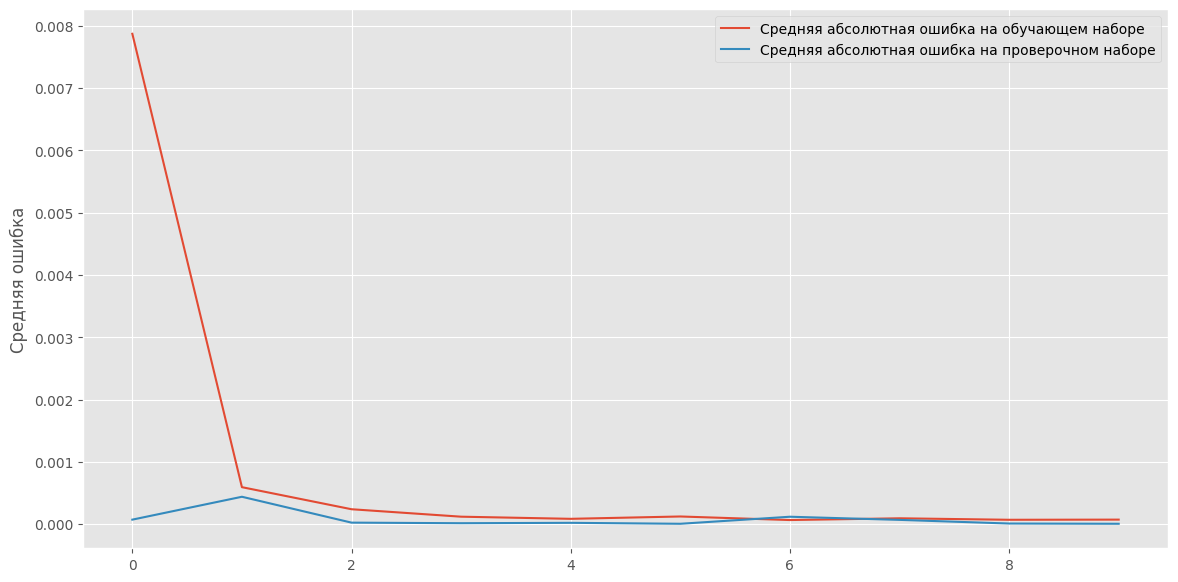

In [ ]:
model = Sequential()

model.add(Dense(150,input_shape = (SEQ_LEN, data.shape[1]), activation = "linear" ))
model.add(Flatten())
model.add(Dense(1, activation = "linear"))

model.compile(loss = "mse", optimizer = Adam(0.0001))

history = model.fit_generator(train_datagen,
                              epochs = 10,
                              verbose = 1,
                              validation_data = val_datagen
                              )

model.save('/content/drive/MyDrive/AI/models/timeline_pro_1.h5')

plt.plot(history.history['loss'], label = 'Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label = 'Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
model = load_model('/content/drive/MyDrive/AI/models/timeline_pro_1.h5')

In [ ]:
pred = get_pred(model, x_test, y_test, y_scaler)

910/910 [==============================] - 2s 2ms/step


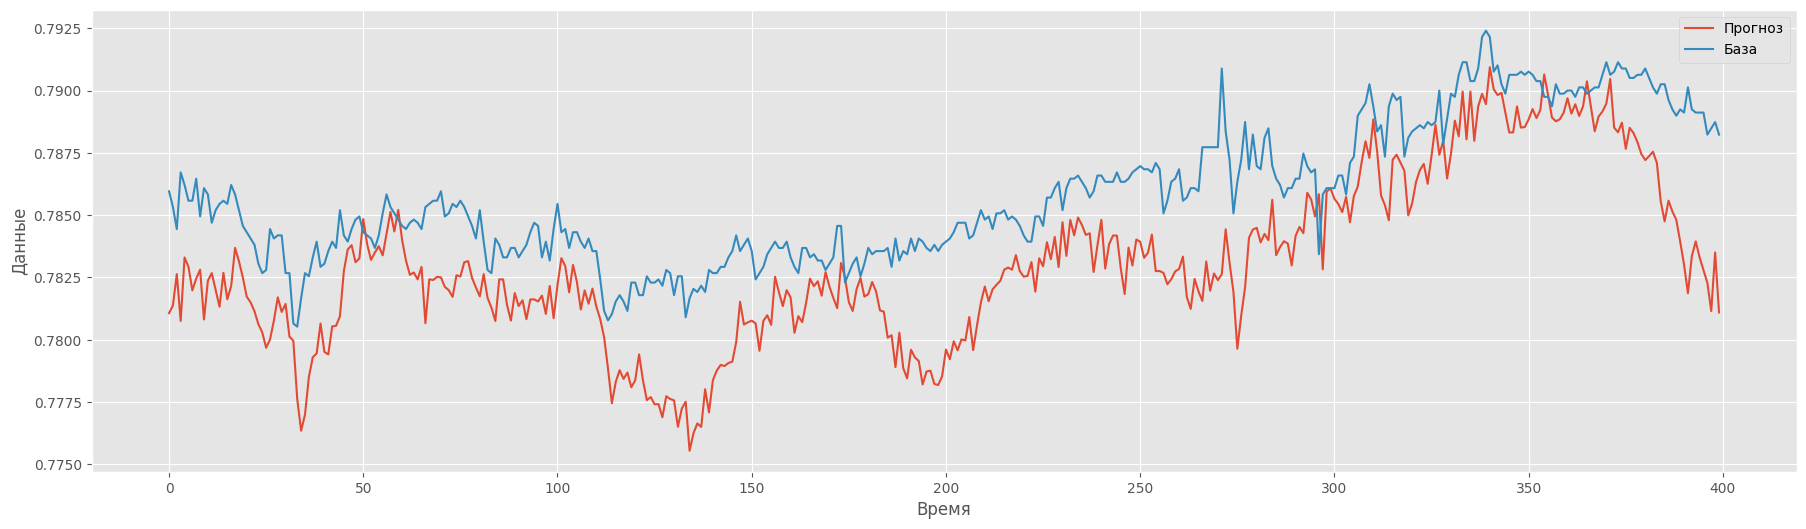

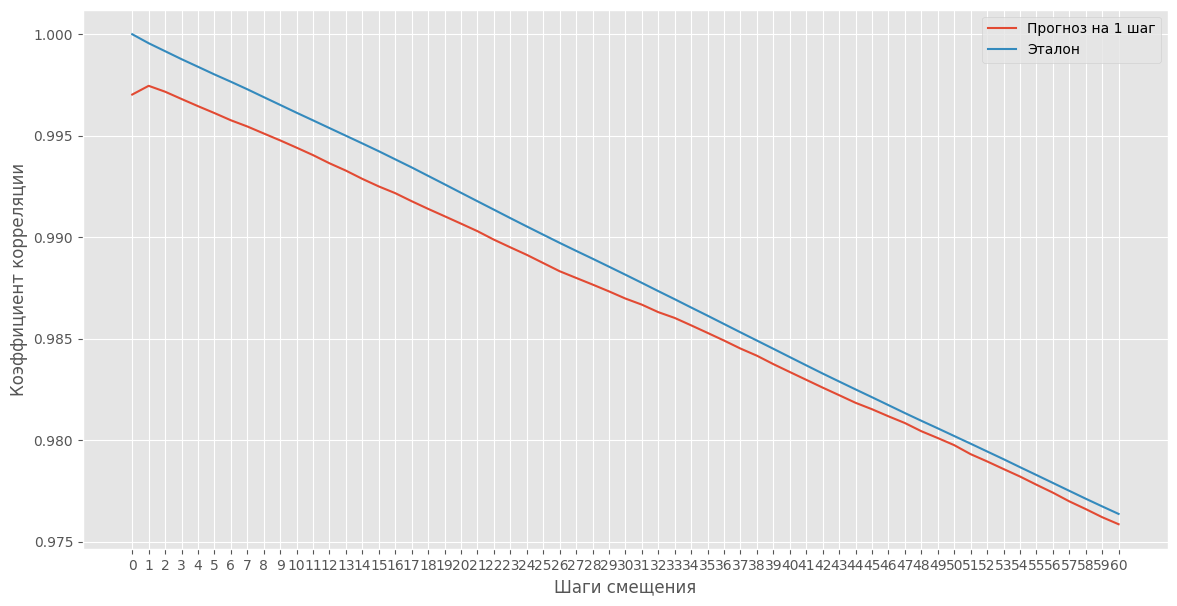

In [ ]:
show_pred(pred[0], pred[1], 0, 400)
show_corr(pred[0], pred[1], 60)

# Новый подход: подготовка данных

In [ ]:
data16_17 = pd.read_csv('16_17.csv', sep=';').drop(columns=['DATE', 'TIME'])
data18_19 = pd.read_csv('18_19.csv', sep=';').drop(columns=['DATE', 'TIME'])

data = pd.concat([data16_17,data18_19])
data = data.reset_index(drop = True)

In [ ]:
def DataGenerator(x,
                  y,
                  DOT_NUM = 100,
                  LINE_LEN = 100,
                  STEP = 10,
                  stride = 1):
    x_data, y_data = [], []

    DOT_LEN = DOT_NUM * STEP
    lenght = DOT_LEN + LINE_LEN

    for i in range(x.shape[0] - lenght):
        dot_line = x[i : i + DOT_LEN : STEP]
        line = x[i + DOT_LEN : i + DOT_LEN + LINE_LEN]
        batch = np.concatenate([dot_line, line])

        x_data.append(batch)
        y_data.append(y[i + DOT_LEN + LINE_LEN + stride - 1])
    return np.array(x_data), np.array(y_data)

In [ ]:
SEQ_LEN = 100
TEST_LEN = 30000
TRAIN_LEN = data.shape[0] - TEST_LEN
BATCH_SIZE = 20

DEPTH = 100
STEP = 10

In [ ]:
x_train = data[: TRAIN_LEN]
x_test = data[TRAIN_LEN + SEQ_LEN * STEP :]

x_scaler = MinMaxScaler()
x_scaler.fit(x_train)
x_train = x_scaler.transform(x_train)
x_test = x_scaler.transform(x_test)

y_train = np.reshape(x_train[:, 3], (-1, 1))
y_test = np.reshape(x_test[:, 3], (-1, 1))

y_scaler = MinMaxScaler()
y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

In [ ]:
x_train, y_train = DataGenerator(x_train, y_train)
x_test, y_test = DataGenerator(x_test, y_test)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(450772, 200, 5)
(450772, 1)
(27900, 200, 5)
(27900, 1)


# Новый подход: Модель

Epoch 1/10
14087/14087 [==============================] - 98s 7ms/step - loss: 1.3147e-04 - val_loss: 4.6317e-05
Epoch 2/10
14087/14087 [==============================] - 80s 6ms/step - loss: 2.2333e-05 - val_loss: 2.5078e-05
Epoch 3/10
14087/14087 [==============================] - 79s 6ms/step - loss: 1.0744e-05 - val_loss: 9.8747e-06
Epoch 4/10
14087/14087 [==============================] - 79s 6ms/step - loss: 6.5026e-06 - val_loss: 2.8837e-06
Epoch 5/10
14087/14087 [==============================] - 79s 6ms/step - loss: 5.0990e-06 - val_loss: 1.5091e-05
Epoch 6/10
14087/14087 [==============================] - 78s 6ms/step - loss: 3.8653e-06 - val_loss: 2.5934e-06
Epoch 7/10
14087/14087 [==============================] - 78s 6ms/step - loss: 3.0799e-06 - val_loss: 2.4909e-06
Epoch 8/10
14087/14087 [==============================] - 79s 6ms/step - loss: 2.7801e-06 - val_loss: 6.5682e-06
Epoch 9/10
14087/14087 [==============================] - 79s 6ms/step - loss: 2.5840e-06 - val_

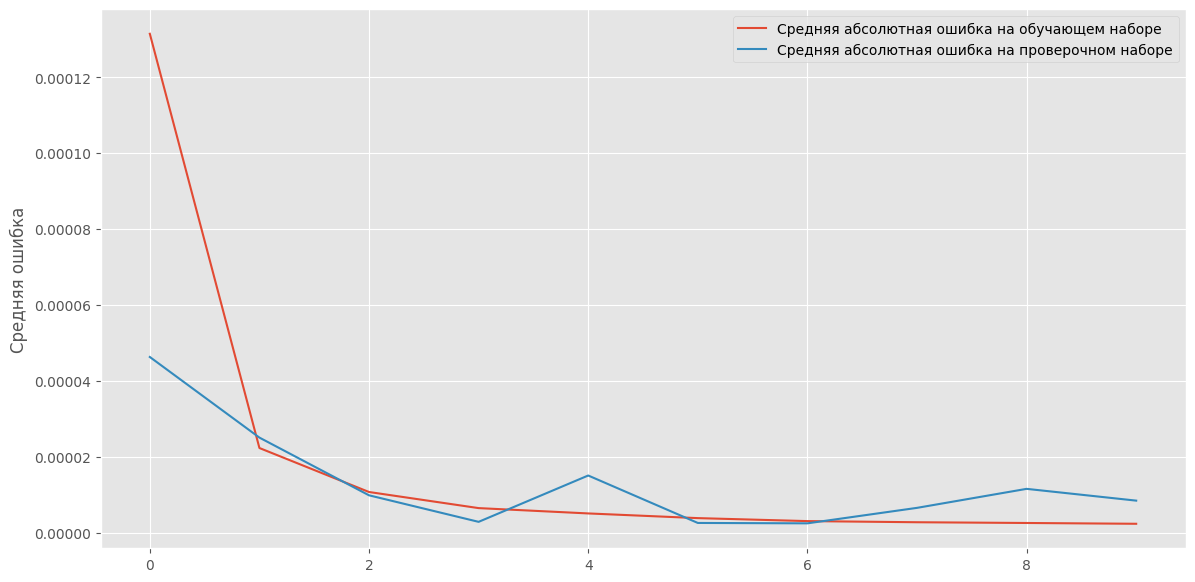

In [ ]:
model = Sequential()

model.add(Dense(150, input_shape = (200, data.shape[1]), activation = "linear" ))
model.add(Flatten())
model.add(Dense(1, activation = "linear"))

model.compile(loss = "mse", optimizer = Adam(0.0001))

history = model.fit(x_train,
                    y_train,
                    epochs = 10,
                    verbose = 1,
                    validation_data = (x_test, y_test)
                    )

model.save('/content/drive/MyDrive/AI/models/timeline_pro_2.h5')

plt.plot(history.history['loss'], label = 'Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label = 'Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

872/872 [==============================] - 2s 3ms/step


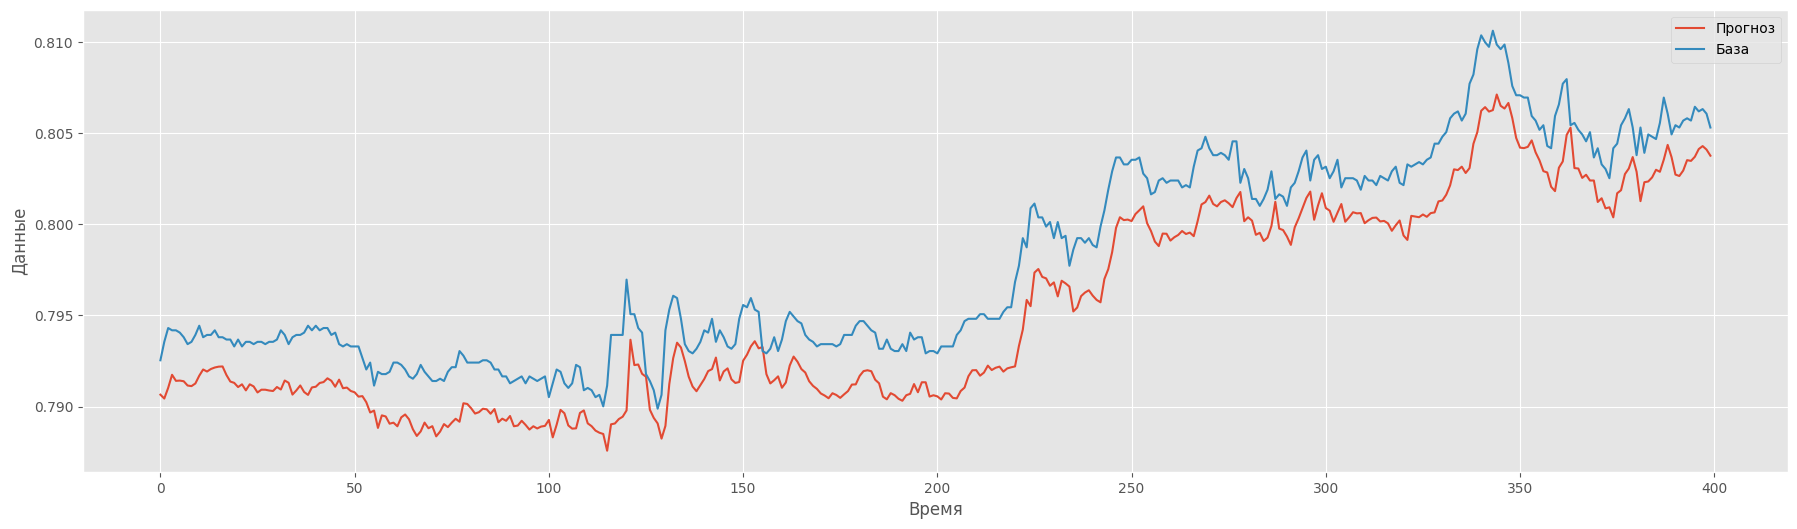

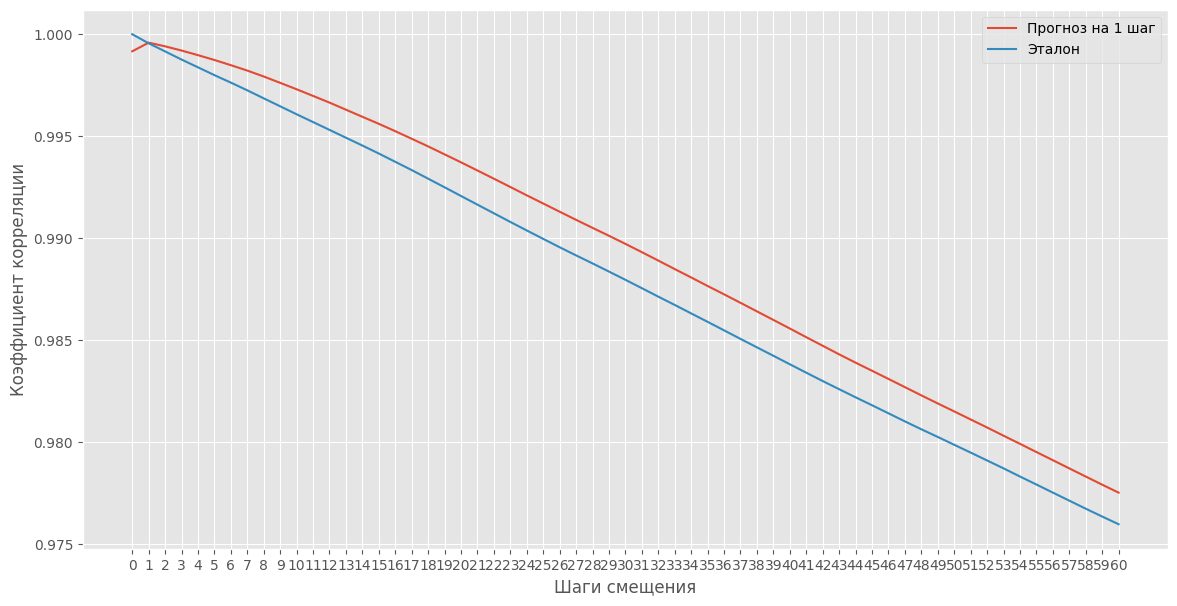

In [ ]:
pred = get_pred(model, x_test, y_test, y_scaler)
show_pred(pred[0], pred[1], 0, 400)
show_corr(pred[0], pred[1], 60)